# Случайность в вероятности и на практике

О подходах к понятию случайности: 

Н.К. Верещагин, В.А. Успенский, А. Шень. Колмогоровская сложность и алгоритмическая случайность. 
https://www.mccme.ru/free-books/shen/kolmbook.pdf

А.Н. Ширяев. Случайность в вероятности (доклад на семинаре кафедры теории веротяностей). http://www.mathnet.ru:8080/PresentFiles/21897/bsk_2018_10_17_shiryaev_an_randomness_in_probability_slides.pdf

## Генераторы случайных чисел

Что происходит при вызове, напрмер, ```np.random.rand()```?

Как устроен источник случайной последовательности?

![img](https://cdn.ablebits.com/_img-blog/random-generator/random-generator.png)

Рассмотрим простой и популрный алгоритм - Linear congruential generator (LCG). При вызове функции ```rand()``` в C/C++ происзодит обращение именно к LCG.

Linear congruential generator производит последовательность:
$$ z_{i+1} = (az_i + c) \mod m $$

Число $z_0$ называется *seed* и обеспечивает воспроизводимость последовательности “случайных” чисел.

Напишем функцию, которая реализует LCG:

In [ ]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m

# setting the seed
rng.current = 1

Выведем несколько первых элементов последовательности:

In [ ]:
[rng() for i in range(10)]

[0.25693503906950355,
 0.5878706516232342,
 0.15432575810700655,
 0.767266943352297,
 0.9738139626570046,
 0.5858681506942958,
 0.8511155843734741,
 0.6132153405342251,
 0.7473867232911289,
 0.06236015981994569]

Выбор параметров $m$, $a$ и $c$ существенно влияет на качество последовательности. Если параметры выбрать наобум, это может привести к неожиданным последствиям:

In [ ]:
def rng(m=97, a=5, c=0):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 7

random = [rng() for i in range(1000)]
print("This sequence looks as random:")
random[:10]

This sequence looks as random:


[0.36082474226804123,
 0.8041237113402062,
 0.020618556701030927,
 0.10309278350515463,
 0.5154639175257731,
 0.5773195876288659,
 0.8865979381443299,
 0.4329896907216495,
 0.16494845360824742,
 0.8247422680412371]

Гистограмма распределения похожа на равномерное:

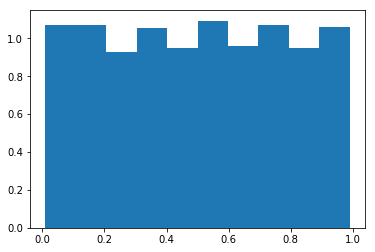

In [ ]:
import matplotlib.pyplot as plt
plt.hist(random, normed=True)
plt.show()

Однако, спектральный тест показывает, что точки располагаются на гиперплоскостях, что плохо согласуется с предствалением о случайности:

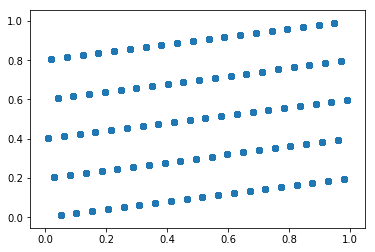

In [ ]:
plt.scatter(random[1:], random[:-1])
plt.show()

Более аккуратный выбор параметров приводит с более "случайному" распределению:

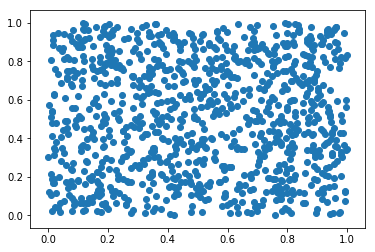

In [ ]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 1

random = [rng() for i in range(1000)]
plt.scatter(random[1:], random[:-1])
plt.show()

Существует набор тестов для проверки "случайности". Например, тесты [Diehard tests](https://en.wikipedia.org/wiki/Diehard_tests).

Больше методов генерации собрано [здесь](https://en.wikipedia.org/wiki/List_of_random_number_generators).

Сюжет про динамические системы и переход к хаосу https://www.youtube.com/watch?v=ovJcsL7vyrk&feature=youtu.be

## Генерация выборки из заданного распределения

Допустим, у нас есть генератор случайных числе из отрезка [0, 1]. Как получить выборку из нового распределения $F$?



### Задача
Смоделировать выборку объема 1000 из дискретного распределения на множестве цифр 0, 1, 2, ..., 9 с весами 0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2. По выборке построить гистограмму. Оптимизируйте алгоритм, упорядочив веса. Сравните время генерации выборки с неупорядоченными и упорядоченными весами.


time without sort:  0.0019953250885009766


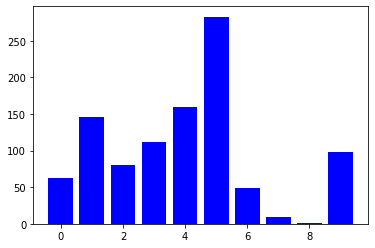

time with sort:  0.003480672836303711


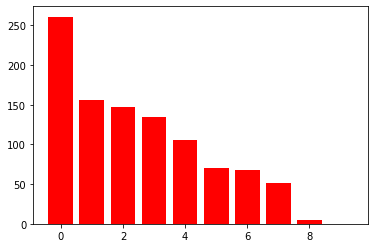

In [2]:
import time as t
import numpy as np
import matplotlib.pyplot as plt

arr = np.array([0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2])
arr /= arr.sum()
t1 = t.time()
tmp = [arr[:i].sum() for i in range(1,11)]
ran = [np.random.rand() for i in range(1000)]
res = []
for i in range(1000):
    for j in range(10):
        if ran[i] < tmp[j]:
            res.append(j)
            break
t2 = t.time()
print ("time without sort: ", t2 - t1)
plt.bar(np.arange(10), [res.count(i) for i in range(10)], color = 'blue')
plt.show()


arr = np.sort(arr)[::-1]
t3 = t.time()
tmp = [arr[:i].sum() for i in range(1,11)]
ran = [np.random.rand() for i in range(1000)]
res = []
for i in range(1000):
    for j in range(10):
        if ran[i] < tmp[j]:
            res.append(j)
            break
t4 = t.time()
print("time with sort: ", t4 - t3)
plt.bar(np.arange(10), [res.count(i) for i in range(10)], color = 'red')
plt.show()

### Inverse transform method

В следующем предложении заключается идея метода *inverse transform*:

Если $\xi$ имеет равномерное распределение в $[0,1]$, тогда $F^{-1}(\xi)$ распределена по закону $F$. (Для каких $F$ это верно?)

### Задача
Смоделируйте выборку размера 1000 из распределения $Exp(\lambda)$. Постройте выборочную гистограмму и точный график плотности распределения.

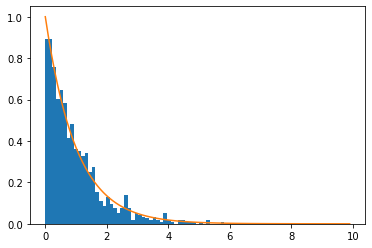

In [3]:
from math import log
import scipy.stats 
lymda = 1

ran = [-log(1 - np.random.rand())/lymda for i in range(1000)]
plt.hist(ran, density=True, bins = 50)
r = np.arange(0, 10, .1)
plt.plot(r, scipy.stats.expon.pdf(r, scale=1))
plt.show()

### Rejection sampling (Accept-reject method)

Идея метода: сэмплить из распределения, из которого умеем, а затем отбирать точки, которые следуют нужному распределению. Картинка иллюстрирует идею метода:
<img src=https://colcarroll.github.io/hamiltonian_monte_carlo_talk/images/bayes_talk.015.png style="width: 50%;"/>
 

### Задача
Обоснуйте, что метод accept-reject действительно производит выборку из нужного распределения. Смоделируйте 1000 точек из усеченного распределения Коши, приведенного ниже, используя генератор равномерного распределения. Нарисуйте график полученной выборочной гистограммы и сравните его с графиком точной функции плотности.

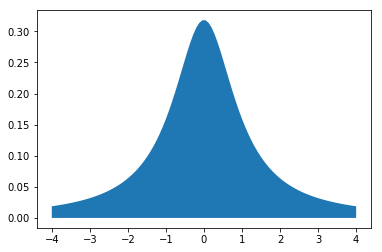

In [ ]:
from scipy import stats
import numpy as np
dist = stats.cauchy()
x = np.linspace(-4, 4, 100)
plt.fill_between(x, 0, dist.pdf(x)) #needs to be normalized!
plt.show()

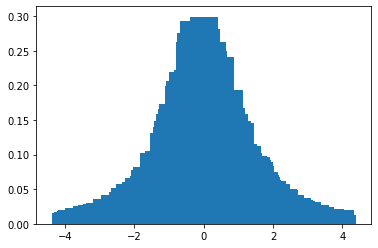

In [4]:
from math import pi
ran = [8*np.random.rand()-4 for i in range(1000)]
ran.sort()
res = []
for i in range (1000):
    x = np.random.rand()/pi
    while (x >= 1/(pi*(1 + ran[i]*ran[i]))):
        x = np.random.rand()/pi
    res.append(x)

plt.bar(ran, res)
plt.show()

##  Coordinate transformation method

Метод аccept-reject в ряде случаев может оказываться неэффективным и требовать слишком много пробных точек. Альтернатива -  попробовать найти преобразование координат, которое переводит простую область (из которой легко сэмплить, например, едининчный квадрат) в требуемую, но при этом сохраняет соотношение площадей.

### Задача
Смоделировать выборку из 500 точек равномерно распределенных внутри данного треугольника без использования метода отбора. 

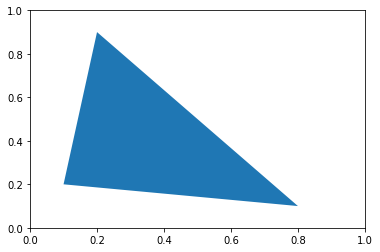

In [12]:
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

polygon = Polygon(0.1 * np.array([[1, 2], [2, 9], [8, 1]]), True)
plt.gca().add_collection(PatchCollection([polygon]))
plt.show()

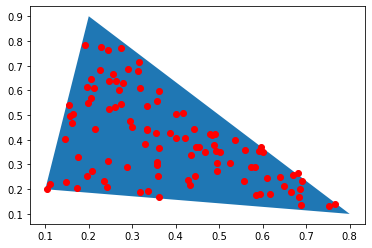

In [22]:
x = np.array([np.random.rand() for i in range(100)])
y = np.array([np.random.rand() for i in range(100)])
x[(x + y) > 1] = 1 - x[(x + y) > 1]
y[(x + y) > 1] = 1 - y[(x + y) > 1]

x =  0.7 * x + 0.1 * y + 0.1
y =  0.7 * y - 0.1 * x + 0.2
polygon = Polygon(0.1 * np.array([[1, 2], [2, 9], [8, 1]]), True)
plt.gca().add_collection(PatchCollection([polygon]))
plt.scatter(x, y, color = 'red')
plt.show()


### Задача
Смоделировать выборку из 500 точек внутри данного круга без использования метода отбора.

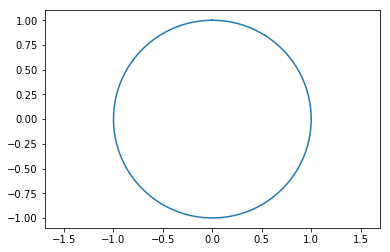

In [ ]:
from matplotlib.patches import Circle
t = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.axis('equal')
plt.show()

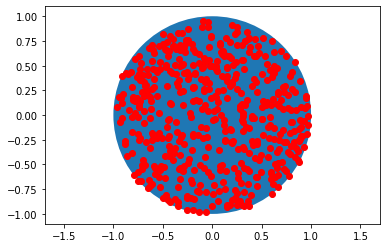

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
circle = Circle(np.array([0, 0]), 1)
plt.gca().add_collection(PatchCollection([circle]))
plt.axis('equal')
r = (np.random.uniform(0, 1,500))
phi = np.pi * np.random.uniform(0, 2,500)

x = np.sqrt(r)*np.cos(phi)
y = np.sqrt(r)*np.sin(phi)
plt.scatter(x,y, color = 'red')
plt.show() 

### Задача
Напишите функцию, которая моделирует случайное симметричное блуждание на двумерной решетке длины n c началом и концом в точке (0, 0). Приведите графики выборочных траекторий для n=100.

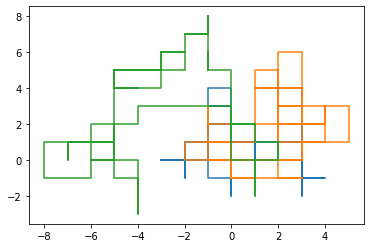

In [7]:
def random_walking(n):
    a = np.random.choice(n, n//2, replace = False)
    b = np.random.choice(n, n//2, replace = False)
    e = [1, -1]
    x_t = np.array([e[i in a] for i in range(100)])
    x = np.array([sum(x_t[:i]) for i in range(101)])
    y_t = np.array([e[i in b] for i in range(100)])
    y = np.array([sum(y_t[:i]) for i in range(101)])
    x_t = x
    x = x_t/2 + y/2
    y = y/2 - x_t/2
    plt.plot(x, y)
random_walking(100)
random_walking(100)
random_walking(100)

## Random normal generator

### Задача
Докажите, что приведенный ниже алгоритм (Box-Muller algorithm) формирует выборку из независимых N(0,1) случаных величин. Модифицируйте метод, чтобы исключить вызовы тригонометрических функций ```np.sin``` и ```np.cos```. С помощью модифицированного метода смоделируйте выборку объема 1000 из двумерного гауссовского распределения со средним (3, 6) и ковариационной матрицей ((2, 1), (1, 4)). Постройте 2D гистограмму полученного распределения.

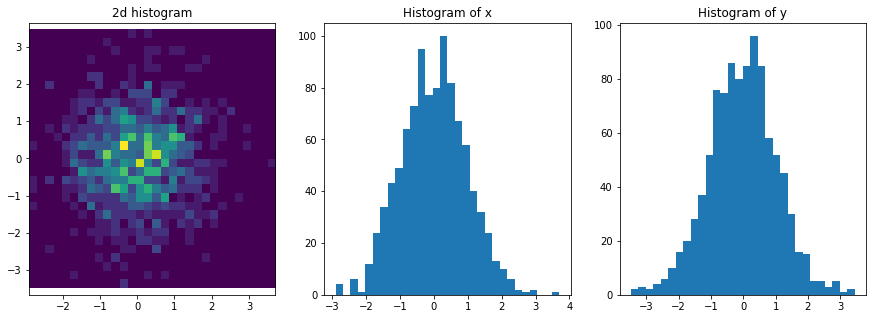

In [ ]:
n = 1000
u1, u2 = np.random.rand(2, n)
r = np.sqrt(-2 * np.log(u1))
theta = 2 * np.pi * u2
x = r * np.cos(theta)
y = r * np.sin(theta)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist2d(x, y, bins=30)
ax[0].axis('equal')
ax[1].hist(x, bins=30)
ax[2].hist(y, bins=30)
ax[0].set_title("2d histogram")
ax[1].set_title("Histogram of x")
ax[2].set_title("Histogram of y")
plt.show()

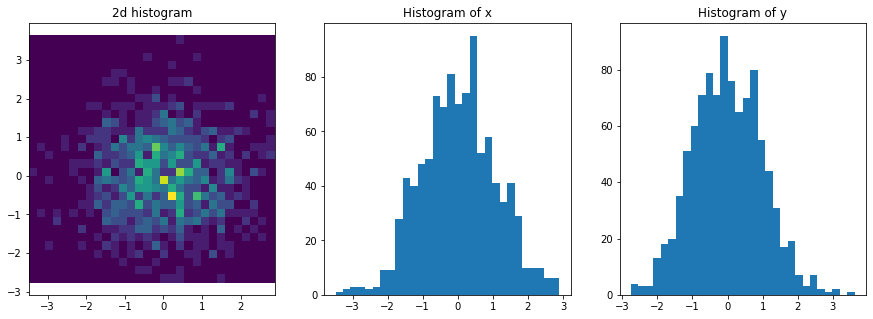

In [8]:
n = 1000
u1, u2 = np.random.rand(2, n)
r = np.sqrt(-2 * np.log(u1))
theta = 2 * np.pi * u2
x = r * np.cos(theta)
y = r * np.sin(theta)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist2d(x, y, bins=30)
ax[0].axis('equal')
ax[1].hist(x, bins=30)
ax[2].hist(y, bins=30)
ax[0].set_title("2d histogram")
ax[1].set_title("Histogram of x")
ax[2].set_title("Histogram of y")
plt.show()


### Задача
С помощью метода Монте-Карло (бросанием случайной точки в квадрат) оцените число $\pi$. Теоретически обоснуйте необходимое число бросаний, чтобы оценить число $\pi$ с точностью 3 знака после запятой и достоверностью 99%. С помощью метода Монте-Карло оцените, сколько на практике требуется бросаний, чтобы достичь с требуемой достоверностью нужной точности.


 Из неравенства Чебышева для сумм независимых индикаторов равновероятных множеств имеем:
 $P\left( |X_n - \mu| > a\right ) < \frac{\mu (1 - \mu)}{a^2n}$.

 Мы хотим вычислить n - необходимое число испытани, чтобы погрешность a составляла $\frac{1}{10000}$ с вероятностью не менее 99%. То есть условие на n:

$n > 10^8  10^2 \mu (1 - \mu)$ - число 9 порядка.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
circle = Circle(np.array([0, 0]), 1)
x = (np.random.uniform(-1, 1,100000000))
y = (np.random.uniform(-1, 1,100000000))
z = x*x + y*y
num = (z < 1).sum()
a = 4 * num / 100000000
print (a)

3.14150944


### Задача

Реализовать метод генерации случайного разбиения n-элементного множества на подмножества. С его помощью оценить ожидаемое число подмножеств в случайном разбиении множества из 100 элементов. 

Подсказка 1: Ширяев, Вероятность, т1, задача 2 к параграфу 1.

Подсказка 2: http://djalil.chafai.net/blog/2012/05/03/generating-uniform-random-partitions/

In [25]:
def part(n):
    b = 0
    tmp = 0
    bypart = []
    ran = np.random.rand()
    for k in range(100):
        b+=(k+1)**n/np.math.factorial(k+1)
    b*=1/np.exp(1)
    p = np.array([(k+1)**n/(b*np.math.factorial(k+1)*np.exp(1)) for k in range(100)])
    arr_sum = np.cumsum(p)
    
    while 1:
        if ran < arr_sum[tmp]:
            ran = tmp+1
            break;
        else:
            tmp+=1
    
    p = [1/ran for i in range(ran)]
    arr_sum = np.cumsum(p)
    arr_ran = [np.random.rand() for i in range(n)]
    for i in range(n):
        tmp=0
        while tmp!=-1:
            if arr_sum[tmp]>arr_ran[i]:
                bypart.append(tmp)
                tmp=-1
            else:
                tmp+=1
    return bypart

#LBN
number = 0
for i in range(10000):
    bypart = part(100)
    number+=len(np.unique(bypart))
print('Expected value = ', number/10000)

Expected value =  28.5979
